# Setup

In [1]:
# Import Packages

import os
import torch
if torch.backends.mps.is_available():
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# for data wrangling
import pandas as pd
import numpy as np

# for visaualization
import seaborn as sns
import matplotlib.pyplot as plt

# for text classification
from openai import OpenAI
import re
from dotenv import load_dotenv

# for text processing
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
#from nltk.translate.bleu_score import sentence_bleu
#from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import SmoothingFunction

In [2]:
# Set Device
# Set device to CUDA, if not to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Load & Preview Datasets

Rauh_Schwalbach_2020 - ParlSpeech V2 data: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L4OAKN
Blumenau_2021 - House of Commons Parliamentary Debates data: https://reshare.ukdataservice.ac.uk/854292/

**Rauh_Schwalbach_2020_ParlSpeech**

In [24]:
# Load Data
data_dir = os.path.join('..', 'data', '')

# Rauh_Schwalbach_2020_ParlSpeech
df_LibDem = pd.read_csv(data_dir + 'Rauh_Schwalbach_2020_ParlSpeech/df_LibDem.csv')
df_Con = pd.read_csv(data_dir + 'Rauh_Schwalbach_2020_ParlSpeech/df_Con.csv')
df_Lab = pd.read_csv(data_dir + 'Rauh_Schwalbach_2020_ParlSpeech/df_Lab.csv')


In [20]:
# What is the top 5 most frequent 'agenda' in the dataset?
print(df_LibDem['agenda'].value_counts().head(3))
print(df_Con['agenda'].value_counts().head(3))
print(df_Lab['agenda'].value_counts().head(3))

agenda
Business of the House                                       1074
Finance Bill                                                1002
Engagements [Oral Answers to Questions > Prime Minister]     730
Name: count, dtype: int64
agenda
Business of the House                                       20117
Engagements [Oral Answers to Questions > Prime Minister]    11849
Finance Bill                                                 3173
Name: count, dtype: int64
agenda
Business of the House                                       11751
Engagements [Oral Answers to Questions > Prime Minister]     7066
Business Of The House                                        5237
Name: count, dtype: int64


In [22]:
# What is the time frame of the 'date' in the dataset?
print(df_LibDem['date'].min(), df_LibDem['date'].max())
print(df_Con['date'].min(), df_Con['date'].max())
print(df_Lab['date'].min(), df_Lab['date'].max())

2000-01-10 2019-12-17
2000-01-10 2019-12-17
2000-01-10 2019-12-17


**Blumenau_2021**

In [66]:
# Load Data
data_dir = os.path.join('..', 'data', '')

# Blumenau_2021
df_HoC_BoH_2019 = (pd.read_csv(data_dir + 'Blumenau_2021/2019.csv', parse_dates=['hdate'])
                   .query("parent == 'Business of the House'")
                   .loc[:, ['epobject_id', 'name', 'constituency', 'age_years', 'gender', 'party_short', 
                            'hdate', 'body', 'parent', 'n_words', 'holds_government_position']] )
# del df_HoC_BoH_2019

C:\Users\chanho\AppData\Local\Temp\ipykernel_2612\1562032008.py:5: DtypeWarning: Columns (26,30,64,65,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df_HoC_BoH_2019 = (pd.read_csv(data_dir + 'Blumenau_2021/2019.csv', parse_dates=['hdate'])


<Axes: xlabel='n_words', ylabel='Count'>

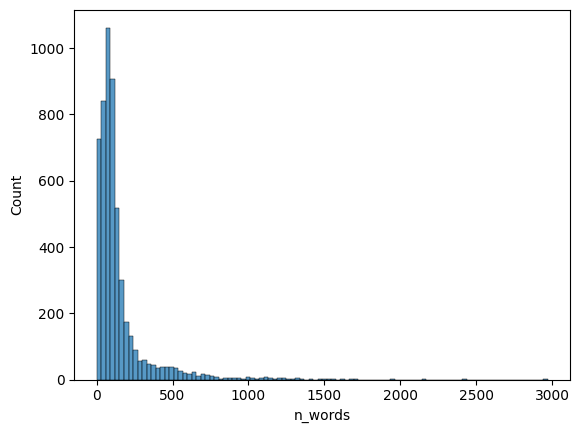

In [40]:
# What is distribution of 'n_words' in the dataset
sns.histplot(df_HoC_BoH_2019['n_words'], bins=100)

In [41]:
# What is the frequencey of the 'party_short' in the dataset
df_HoC_BoH_2019['party_short'].value_counts()

party_short
Conservative                         2948
Labour                               1266
Other                                 591
SNP                                   458
LibDem                                 71
The Independent Group for Change       40
Green                                   9
Change UK - The Independent Group       4
Name: count, dtype: int64

hdate
2019-01-10    122
2019-01-15     16
2019-01-16    353
2019-01-17    105
2019-01-24     67
2019-01-28     38
2019-01-31    105
2019-02-07     89
2019-02-13     34
2019-02-14    455
2019-02-26     88
2019-02-28     84
2019-03-07     59
2019-03-12    365
2019-03-13     54
2019-03-14    328
2019-03-18     44
2019-03-21    108
2019-03-26     42
2019-03-27    139
2019-03-28    243
2019-04-01     75
2019-04-03    225
2019-04-04     70
2019-04-08     65
2019-04-11    119
2019-04-23      4
2019-04-25     75
2019-05-02     97
2019-05-09     72
2019-05-16     77
2019-06-06     79
2019-06-13     65
2019-06-20     72
2019-06-27     72
2019-07-04     96
2019-07-08      9
2019-07-11     69
2019-07-18     81
2019-09-25     49
2019-09-26    190
2019-10-03     83
2019-10-08     64
2019-10-17    179
2019-10-21    128
2019-10-22     64
2019-10-24    169
2019-10-28     63
2019-10-29     18
2019-10-30     20
Name: count, dtype: int64


<Axes: xlabel='month_year'>

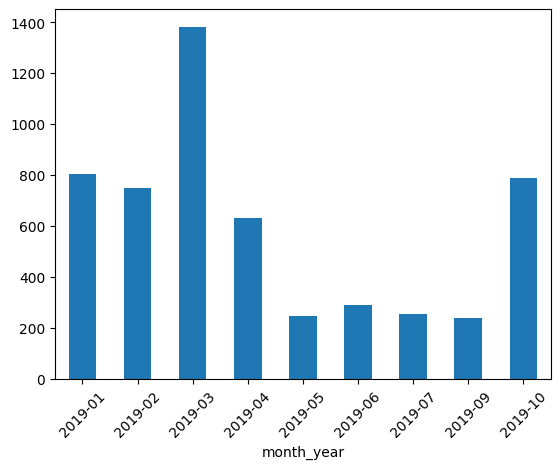

In [61]:
# What is the frequencey of speech of each day
print(df_HoC_BoH_2019['hdate'].value_counts().sort_index())

# Visualize barplot the frequencey of speech of each month, 45 degree slanted x-axis
df_HoC_BoH_2019['hdate'] = pd.to_datetime(df_HoC_BoH_2019['hdate'])
df_HoC_BoH_2019['month'] = df_HoC_BoH_2019['hdate'].dt.month
df_HoC_BoH_2019['year'] = df_HoC_BoH_2019['hdate'].dt.year
df_HoC_BoH_2019['month_year'] = df_HoC_BoH_2019['hdate'].dt.to_period('M')
df_HoC_BoH_2019['month_year'] = df_HoC_BoH_2019['month_year'].dt.to_timestamp()
df_HoC_BoH_2019['month_year'] = df_HoC_BoH_2019['month_year'].dt.strftime('%Y-%m')

df_HoC_BoH_2019['month_year'].value_counts().sort_index().plot(kind='bar', rot=45)


In [69]:
# Subset the data 

# 2019, Feb-07
df_HoC_BoH_2019_Feb07 = df_HoC_BoH_2019.query("hdate == '2019-02-07' & party_short != 'Other'")

# 2019 March
df_HoC_BoH_2019_March = df_HoC_BoH_2019.query("hdate >= '2019-03-01' & hdate <= '2019-03-31' & party_short != 'Other'")

# 2019 April
df_HoC_BoH_2019_April = df_HoC_BoH_2019.query("hdate >= '2019-04-01' & hdate <= '2019-04-30' & party_short != 'Other'")


C:\Users\chanho\AppData\Local\Temp\ipykernel_2612\857278087.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_HoC_BoH_2019_Feb07 = df_HoC_BoH_2019.query("hdate == '2019-02-07' & party_short != 'Other'")


In [80]:
df_HoC_BoH_2019_April = df_HoC_BoH_2019_April[df_HoC_BoH_2019_April['n_words'] >= 25]
df_HoC_BoH_2019_April

# Text Classification Using ChatGPT

In [9]:
load_dotenv()
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))
MODEL = 'gpt-4o-2024-08-06' # currently the latest version of GPT-4o (on 2024-09-25)

## Zeroshot Classification

In [11]:
# Define Custom function:
from typing import List

def classify_text(texts: List[str], 
                  model: str, 
                  system_message,):

  # clean the text 
  texts = [re.sub(r'\s+', ' ', text).strip() for text in texts]

  # construct input

  messages = [
    # system prompt (modified to handle multiple inputs)
    {"role": "system", 
     "content": system_message},
    
    # user input
    {"role": "user", 
     "content": "\n".join(texts)},
  ]

  response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=0.0,
    seed=42,
    frequency_penalty=0,
    presence_penalty=0
  )
  
  result = response.choices[0].message.content
  
  return result.split("\n")

In [10]:
instructions = """
This task involves reading sentences from UK Parliamentary speech texts and judging whether these use Dimension Manipulation according to William H. Riker theory of Heresthetic.

## What is "Dimension Manipulation"?
According to William H. Riker theory of Heresthetic, Dimension Manipulation introduces new information & redefines Issues, which can be used to manipulate the outcome of a decision-making process. This involves either Increasing Dimensionality by expanding the Number of Issues Involved; or Fixing Dimensionality by Limiting the Number of Issues Involved.

## Your task
1. Carefully read the speech text, paying close attention to details.
2. Classify the speech as either Dimension Manipulation or No Dimension Manipulation

## Response format
Only respond with the chosen category and no additional text or explanations 
"""

### Classification for a Day

In [ ]:
# Run Classification for 2019 Feb07
from tqdm.notebook import tqdm # for progress bar

texts = df_HoC_BoH_2019_Feb07['body'].tolist()
classifications_2019_Feb07 = [classify_text(text, model=MODEL, 
                                 system_message=instructions) for text in tqdm(texts)]

In [49]:
# Merge Classification Output with the Data
df_HoC_BoH_2019_Feb07_CL = pd.concat([df_HoC_BoH_2019_Feb07.reset_index(drop=True), 
                                      pd.DataFrame(classifications_2019_Feb07, 
                                                   columns=['classification']) ], 
                                      axis=1)

# Save the Output
df_HoC_BoH_2019_Feb07_CL.to_csv(data_dir + 'Blumenau_2021/df_HoC_BoH_2019_Feb07_CL.csv', index=False)

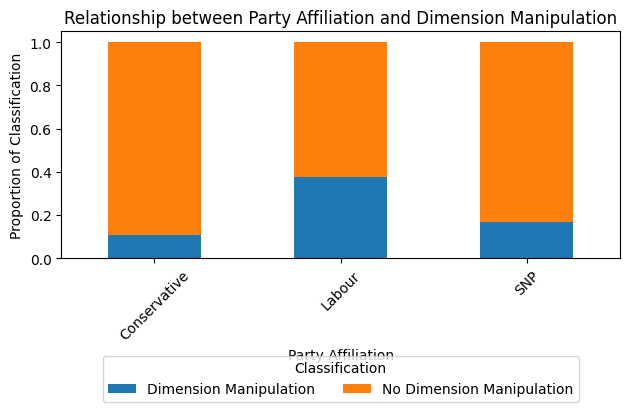

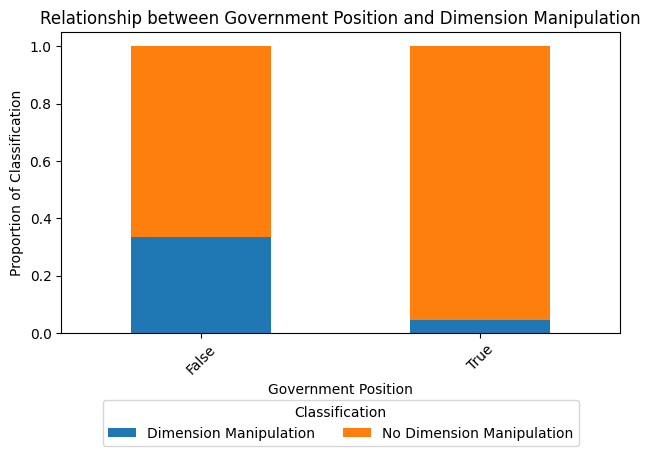

In [85]:
# Visualize Relationships
import matplotlib.pyplot as plt

# First plot: Relationship between 'party_short' and 'Dimension_Manipulation'
df_HoC_BoH_2019_Feb07_CL.groupby('party_short')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Party Affiliation and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Party Affiliation')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()

# Second plot: Relationship between 'holds_government_position' and 'Dimension_Manipulation'
df_HoC_BoH_2019_Feb07_CL.groupby('holds_government_position')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Government Position and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Government Position')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()


### Classification for a Month

In [79]:
# Run Classification for 2019 April
from tqdm.notebook import tqdm # for progress bar

# Filter out 'n_words' < 25 from 'df_HoC_BoH_2019_April'
texts = df_HoC_BoH_2019_April[df_HoC_BoH_2019_April['n_words'] >= 25]['body'].tolist()
classifications_2019_April = [classify_text(text, model=MODEL, 
                                 system_message=instructions) for text in tqdm(texts)]

  0%|          | 0/518 [00:00<?, ?it/s]

[['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['Dimension Manipulation'],
 ['No Dimension Manipulation'],
 ['Dimension Manipulation'],


In [81]:
# Merge Classification Output with the Data
df_HoC_BoH_2019_April_CL = pd.concat([df_HoC_BoH_2019_April.reset_index(drop=True), 
                                      pd.DataFrame(classifications_2019_April, 
                                                   columns=['classification']) ], 
                                      axis=1)

# Save the Output
df_HoC_BoH_2019_April_CL.to_csv(data_dir + 'Blumenau_2021/df_HoC_BoH_2019_April_CL.csv', index=False)

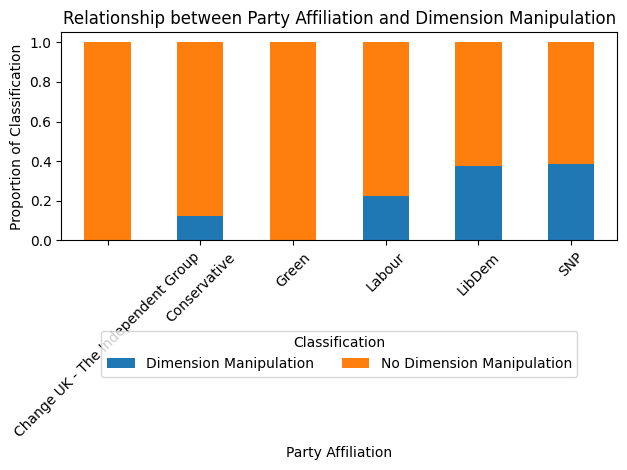

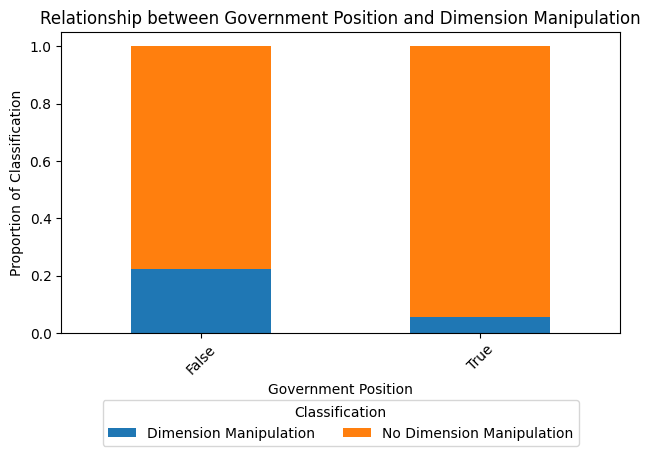

In [86]:
# Visualize Relationships
import matplotlib.pyplot as plt

# First plot: Relationship between 'party_short' and 'Dimension_Manipulation'
df_HoC_BoH_2019_April_CL.groupby('party_short')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Party Affiliation and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Party Affiliation')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()

# Second plot: Relationship between 'holds_government_position' and 'Dimension_Manipulation'
df_HoC_BoH_2019_April_CL.groupby('holds_government_position')['classification'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, rot=45)
plt.title('Relationship between Government Position and Dimension Manipulation')  # Add appropriate title
plt.xlabel('Government Position')  # Label x-axis
plt.ylabel('Proportion of Classification')  # Label y-axis
plt.legend(title='Classification', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)  # Adjust legend position and add a title
plt.tight_layout()  # Ensure layout is adjusted
plt.show()


## Oneshot Classification

In [ ]:
instructions = """
This task involves reading sentences from UK Parliamentary speech texts and judging whether these use Dimension Manipulation according to William H. Riker theory of Heresthetic.

## What is "Dimension Manipulation"?
According to William H. Riker theory of Heresthetic, Dimension Manipulation introduces new information & redefines Issues, which can be used to manipulate the outcome of a decision-making process. This involves either Increasing Dimensionality by expanding the Number of Issues Involved; or Fixing Dimensionality by Limiting the Number of Issues Involved.

## Your task
1. Carefully read the speech text, paying close attention to details.
2. Classify the speech as either Dimension Manipulation or No Dimension Manipulation

## Response format
Only respond with the chosen category and no additional text or explanations 
"""

# Counterfactual Sampling

In [ ]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self._number_of_visits = 0.
        self._results = 0.

    def expand(self):
        # Implement your expansion logic here
        pass

    def rollout(self):
        # Implement your rollout logic here
        pass

    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results += result
        if self.parent:
            self.parent.backpropagate(result)

    def is_fully_expanded(self):
        return len(self.children) > 0

    def best_child(self):
        # Implement your selection logic here
        pass

def MCTS(root, iterations):
    for _ in range(iterations):
        node = root
        while node.is_fully_expanded():
            node = node.best_child()
        if not node.is_terminal():
            node.expand()
        result = node.rollout()
        node.backpropagate(result)
    return root.best_child()
